# 2. Analysis section
This notebook focuses on the Figures for the analysis section of the report and the viva. 

In [3]:
# Import relevant packages
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
%config InlineBackend.figure_formats = ['png']
plt.rcParams['font.size'] = '16'
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

def import_mat(path):
    """Imports .mat file in the saved kwave format
        .mat file should have 3 saved variables as a time series

    Args:
        path (str): relative filepath to .mat file

    Returns:
        data (np.array): 4 dimensional Numpy array of time series data
    """
    data = sio.loadmat(path)['data'][0][0]
    data = np.array([data[i] for i in range(len(data))])
    return data

# 2.A Beam images

<Figure size 432x288 with 0 Axes>

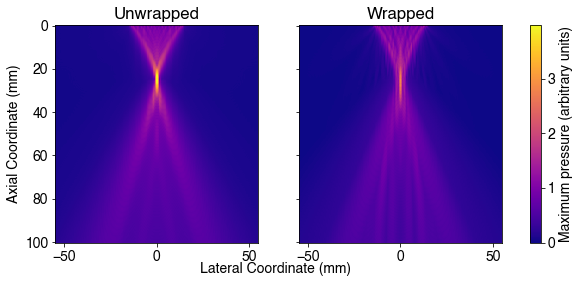

In [43]:
def pressure_plot(data_0, data_1):
    # Grid parameters
    Nx = 236         # Number of grid points
    Ny = 216
    size = 100    # Width of the grid[m]
    dx = size/Nx
    dy = dx

    # Steering parameters
    r = 25e-3       # Steering radius [mm]

    # Plot parameters and variables
    plt.set_cmap('plasma')

    # Set the meshgrid inputs
    x = np.linspace(-1, 1, Nx ) * size/2 *Nx/Ny
    y = np.linspace(0, 1, Ny) * size
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots(1, 2, figsize = (10,4), sharey=True)
    im = ax[0].pcolormesh(X,Y, data_0[0], vmin=0, shading='auto')
    ax[1].pcolormesh(X,Y, data_1[0], vmax = np.max(data_0[0]), shading='auto')

    ax[0].set_ylabel('Axial Coordinate (mm)')
    ax[0].set_title('Unwrapped')
    ax[1].set_title('Wrapped')
    ax[1].invert_yaxis()

    cbar = plt.colorbar(im, ax = ax)
    cbar.set_label('Maximum pressure (arbitrary units)')

    fig.text(0.43, 0.02, 'Lateral Coordinate (mm)', ha='center')
    return

data_0 = import_mat('../raw_data/0322_focus_0_all.mat')
data_1 = import_mat('../raw_data/0322_focus_wrap_0_all.mat')

pressure_plot(data_0, data_1)
plt.savefig('steer-0.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

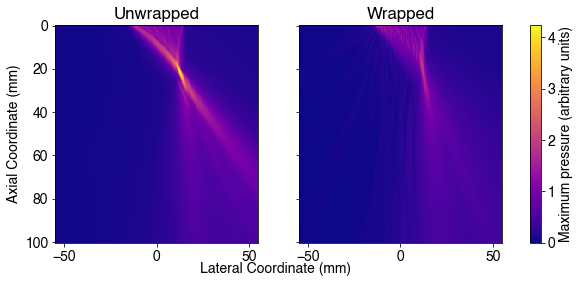

In [44]:
data_0 = import_mat('../raw_data/0322_focus_30_all.mat')
data_1 = import_mat('../raw_data/0322_focus_wrap_30_all.mat')

pressure_plot(data_0, data_1)
plt.savefig('steer-1.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

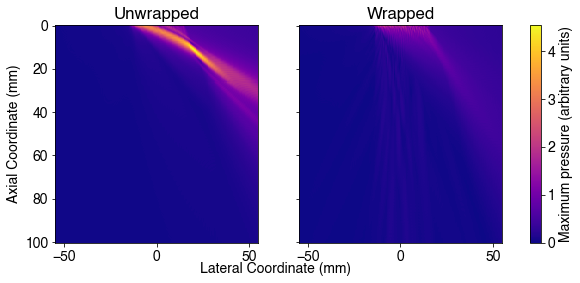

In [45]:
data_0 = import_mat('../raw_data/0322_focus_60_all.mat')
data_1 = import_mat('../raw_data/0322_focus_wrap_60_all.mat')

pressure_plot(data_0, data_1)
plt.savefig('steer-2.png', dpi=300, bbox_inches='tight')

Pressure profiles

# Lateral resolution

Text(0.5, 0, 'Steering angle (deg)')

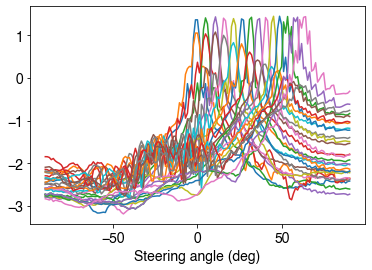

In [47]:
angles = np.arange(0,70,5)
a = np.linspace(-90,90, 153)
p_wrap_max = []
p_unwrap_max = []

for angle in angles:
    data_0 = import_mat(f'../raw_data/0322_focus_{angle}_arc.mat')
    data_1 = import_mat(f'../raw_data/0322_focus_wrap_{angle}_arc.mat')

    plt.plot(a,np.log(np.max(data_0[0], axis=1)))
    plt.plot(a,np.log(np.max(data_1[0], axis=1)))
    p_unwrap_max.append(np.max(data_0))
    p_wrap_max.append(np.max(data_1))

plt.xlabel('Steering angle (deg)')

In [48]:
data_0.shape

(3, 153, 1067)

Pressure variation with beam angle steering

Text(0.5, 0, 'Steering angle (deg)')

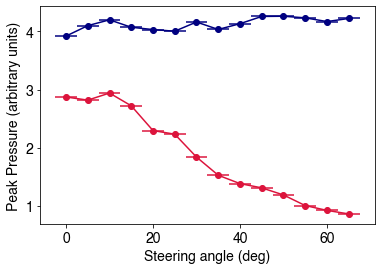

In [49]:
plt.scatter(angles, p_wrap_max, c='crimson')
plt.scatter(angles, p_unwrap_max, c='navy')
plt.errorbar(angles, p_wrap_max, xerr=2.5, c='crimson')
plt.errorbar(angles, p_unwrap_max, xerr=2.5, c='navy')

plt.ylabel('Peak Pressure (arbitrary units)')
plt.xlabel('Steering angle (deg)')

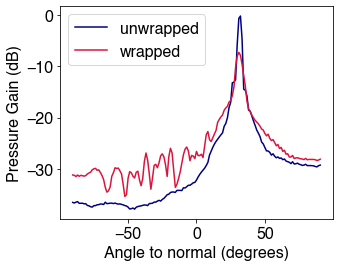

In [67]:
maximum = np.max(p_unwrap_max)

for angle in [30]:
    data_0 = import_mat(f'../raw_data/0322_focus_{angle}_arc.mat')/maximum
    data_1 = import_mat(f'../raw_data/0322_focus_wrap_{angle}_arc.mat')/maximum


    plt.figure(figsize=(5,4))
    plt.plot(a,20*np.log10(np.max(data_0[0], axis=1)), c='navy', label='unwrapped')
    plt.plot(a,20*np.log10(np.max(data_1[0], axis=1)), c='crimson', label='wrapped')
    p_wrap_max.append(np.max(data_0))
    p_unwrap_max.append(np.max(data_1))


plt.ylabel('Pressure Gain (dB)')
plt.xlabel('Angle to normal (degrees)')
plt.legend()

#plt.plot(np.max(data_0[0], axis=1) / np.max(data_1[0], axis=1))
plt.tight_layout()
plt.savefig('beam-profile-1.pdf')

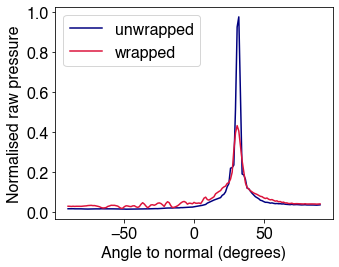

In [66]:
for angle in [30]:
    data_0 = import_mat(f'../raw_data/0322_focus_{angle}_arc.mat')/maximum
    data_1 = import_mat(f'../raw_data/0322_focus_wrap_{angle}_arc.mat')/maximum
    plt.figure(figsize=(5,4))
    plt.plot(a,(np.max(data_0[0], axis=1)), c='navy', label='unwrapped')
    plt.plot(a,(np.max(data_1[0], axis=1)), c='crimson', label='wrapped')
    p_wrap_max.append(np.max(data_0))
    p_unwrap_max.append(np.max(data_1))


plt.ylabel('Normalised raw pressure')
plt.xlabel('Angle to normal (degrees)')
plt.tight_layout()
plt.legend()
plt.savefig('beam-profile-0.pdf')

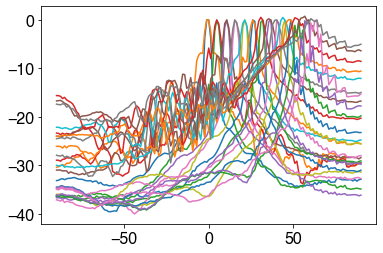

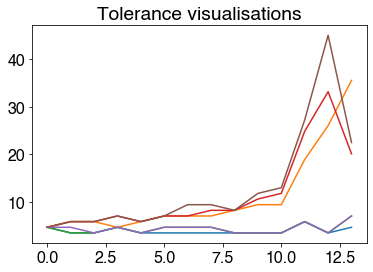

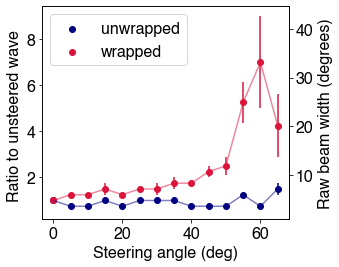

In [76]:
maximum = np.max(p_wrap_max)
width_lo = []
width_mid = []
width_hi = []

# Set thresholds to consider (in -dB)
lo = 5.5
mid = 6
hi = 6.5

# Obtain the first point where a cut array drops below a threshold
# and return the original angle difference
def extract_width(array, thres, max_idx, flip = False):
    if flip:
        idx = np.argmax(array < -thres)
        return a[max_idx + idx] - a[max_idx] 
    else: 
        flipped = np.flip(array)
        idx = np.argmax(flipped < -thres)
        return a[max_idx] - a[max_idx - idx]

for angle in angles:
    # Extract wrapped and unwrapped data
    data_0 = np.max(import_mat(f'../raw_data/0322_focus_{angle}_arc.mat')[0], axis=1)
    data_1 = np.max(import_mat(f'../raw_data/0322_focus_wrap_{angle}_arc.mat')[0], axis=1)

    wrap_max = np.argmax(data_0)


    # Log and take relative magnitude
    data_0 = 20*np.log10(data_0 / data_0[wrap_max])
    data_1 = 20*np.log10(data_1 / data_1[wrap_max])

    width_mid.append([extract_width(data_0[:wrap_max], mid, wrap_max) + extract_width(data_0[wrap_max:], mid, wrap_max, True), 
                     extract_width(data_1[:wrap_max], mid, wrap_max) + extract_width(data_1[wrap_max:], mid, wrap_max, True)])

    width_lo.append([extract_width(data_0[:wrap_max], lo, wrap_max) + extract_width(data_0[wrap_max:], lo, wrap_max, True), 
                     extract_width(data_1[:wrap_max], lo, wrap_max) + extract_width(data_1[wrap_max:], lo, wrap_max, True)])

    width_hi.append([extract_width(data_0[:wrap_max], hi, wrap_max) + extract_width(data_0[wrap_max:], hi, wrap_max, True), 
                     extract_width(data_1[:wrap_max], hi, wrap_max) + extract_width(data_1[wrap_max:], hi, wrap_max, True)])

    plt.plot(a, data_0)
    plt.plot(a, data_1)

#plt.xlim(0,30)

width_lo = np.array(width_lo)
width_mid = np.array(width_mid)
width_hi = np.array(width_hi)


plt.show()

plt.plot(width_lo)
plt.plot(width_mid)
plt.plot(width_hi)

plt.title('Tolerance visualisations')
plt.show()

# Plot the graph with angular variation
fig, ax1 = plt.subplots(figsize=(5,4))


unwrapped, wrapped = width_mid.T
unwrapped_err, wrapped_err = (width_hi - width_lo).T/2
plt.scatter(angles, unwrapped/unwrapped[0], c='navy', label='unwrapped')
plt.scatter(angles, wrapped/unwrapped[0], c='crimson', label='wrapped')
plt.plot(angles, unwrapped/unwrapped[0], c='navy', alpha=0.5, ls='-')
plt.plot(angles, wrapped/unwrapped[0], c='crimson', alpha=0.5, ls='-')

plt.errorbar(angles, unwrapped/unwrapped[0], yerr=unwrapped_err/unwrapped[0], c='navy', ls='')
plt.errorbar(angles, wrapped/unwrapped[0], yerr=wrapped_err/unwrapped[0], c='crimson',ls='')
plt.ylabel('Ratio to unsteered wave ')
plt.xlabel('Steering angle (deg)')
plt.legend()

ax2 = ax1.twinx()
mn, mx = ax1.get_ylim()
ax2.set_ylim(mn*unwrapped[0], mx*unwrapped[0])
ax2.set_ylabel('Raw beam width (degrees)')

#plt.title('Full beam width at -6 dB')
plt.tight_layout()
plt.savefig('lateral-0.pdf')

In [80]:
width_mid

array([[ 4.73684211,  4.73684211],
       [ 3.55263158,  5.92105263],
       [ 3.55263158,  5.92105263],
       [ 4.73684211,  7.10526316],
       [ 3.55263158,  5.92105263],
       [ 4.73684211,  7.10526316],
       [ 4.73684211,  7.10526316],
       [ 4.73684211,  8.28947368],
       [ 3.55263158,  8.28947368],
       [ 3.55263158, 10.65789474],
       [ 3.55263158, 11.84210526],
       [ 5.92105263, 24.86842105],
       [ 3.55263158, 33.15789474],
       [ 7.10526316, 20.13157895]])

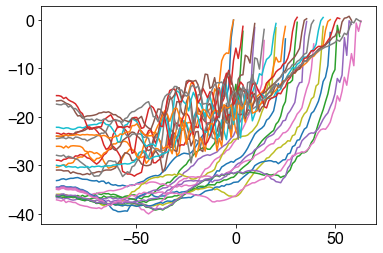

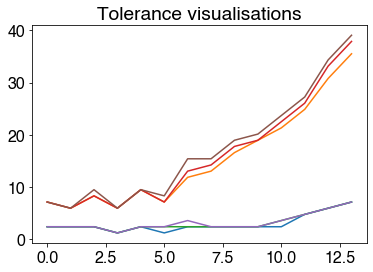

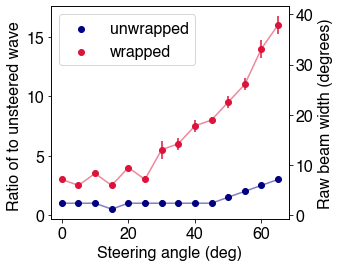

In [77]:
maximum = np.max(p_wrap_max)
width_lo = []
width_mid = []
width_hi = []

# Set thresholds to consider (in -dB)
lo = 11.5
mid = 12
hi = 12.5

# Obtain the first point where a cut array drops below a threshold
# and return the original angle difference
def extract_width(array, thres, max_idx, flip = False):
    if flip:
        idx = np.argmax(array < -thres)
        return a[max_idx + idx] - a[max_idx] 
    else: 
        flipped = np.flip(array)
        idx = np.argmax(flipped < -thres)
        return a[max_idx] - a[max_idx - idx]

for angle in angles:
    # Extract wrapped and unwrapped data
    data_0 = np.max(import_mat(f'../raw_data/0322_focus_{angle}_arc.mat')[0], axis=1)
    data_1 = np.max(import_mat(f'../raw_data/0322_focus_wrap_{angle}_arc.mat')[0], axis=1)

    wrap_max = np.argmax(data_0)


    # Log and take relative magnitude
    data_0 = 20*np.log10(data_0[:wrap_max] / data_0[wrap_max])
    data_1 = 20*np.log10(data_1[:wrap_max] / data_1[wrap_max])

    width_mid.append([extract_width(data_0, mid, wrap_max), 
                    extract_width(data_1, mid, wrap_max)])

    width_lo.append([extract_width(data_0, lo, wrap_max), 
                    extract_width(data_1, lo, wrap_max)])

    width_hi.append([extract_width(data_0, hi, wrap_max), 
                    extract_width(data_1, hi, wrap_max)])

    plt.plot(a[:wrap_max], data_0)
    plt.plot(a[:wrap_max], data_1)

#plt.xlim(0,30)

width_lo = np.array(width_lo)
width_mid = np.array(width_mid)
width_hi = np.array(width_hi)


plt.show()

plt.plot(width_lo)
plt.plot(width_mid)
plt.plot(width_hi)

plt.title('Tolerance visualisations')
plt.show()

# Plot the graph with angular variation
fig, ax1= plt.subplots(figsize=(5,4))
unwrapped, wrapped = width_mid.T
unwrapped_err, wrapped_err = (width_hi - width_lo).T/2
plt.scatter(angles, unwrapped/unwrapped[0], c='navy', label='unwrapped')
plt.scatter(angles, wrapped/unwrapped[0], c='crimson', label='wrapped')
plt.plot(angles, unwrapped/unwrapped[0], c='navy', alpha=0.5, ls='-')
plt.plot(angles, wrapped/unwrapped[0], c='crimson', alpha=0.5, ls='-')

plt.errorbar(angles, unwrapped/unwrapped[0], yerr=unwrapped_err/unwrapped[0], c='navy', ls='')
plt.errorbar(angles, wrapped/unwrapped[0], yerr=wrapped_err/unwrapped[0], c='crimson',ls='')
plt.ylabel('Ratio of to unsteered wave ')
plt.xlabel('Steering angle (deg)')
plt.legend()

ax2 = ax1.twinx()
mn, mx = ax1.get_ylim()
ax2.set_ylim(mn*unwrapped[0], mx*unwrapped[0])
ax2.set_ylabel('Raw beam width (degrees)')

#plt.title('Half beam width at -12 dB')

plt.tight_layout()
plt.savefig('lateral-1.pdf')


When main lobe reaches -2dB.

# 2.B Axial resolution

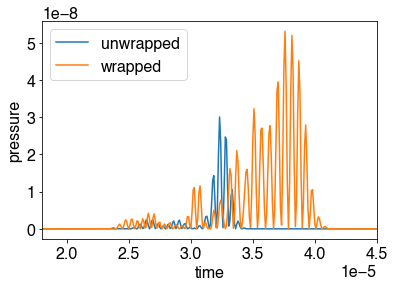

In [79]:
dt = 9.2593e-08 # s

data_0 = import_mat('../raw_data/0322_focus_30_arc.mat')[2]
data_1 = import_mat('../raw_data/0322_focus_wrap_30_arc.mat')[2]
elements = len(data_0[0])


t_range = np.arange(0,len(data_0[0,:])) * dt
#plt.plot(t_range, np.sum(data_0[0], axis=0), label='unwrapped')
#plt.plot(t_range, np.sum(data_1[0], axis=0), label = 'wrapped')

elem = 120
plt.plot(t_range, data_0[elem,:], label='unwrapped')
plt.plot(t_range, data_1[elem,:], label = 'wrapped')
#plt.plot(t_range, data_0[102,:], label = 'ref')
plt.ylabel('pressure')
plt.xlabel('time')

plt.xlim(1.8e-5, 4.5e-5)
plt.legend()


(2e-05, 4e-05)

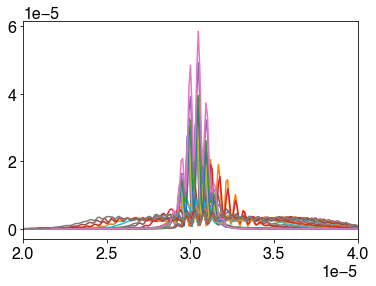

In [80]:
elem = 76
diff = 5
areas = []
lengths = []
widths = []
widths_hi = []
widths_lo = []

from scipy.integrate import simps

def extract_fullwidth(array, thres, t):
    """_summary_

    Args:
        array (array like): time series array
        thres (float): percentage from max

    Returns:
        _type_: _description_
    """
    max_idx = np.argmax(array)
    thres_val = thres * np.max(array)

    # Find time point from the maximum, on either side
    # to which the array first increases above the threshold
    left_idx = np.argmax(array[:max_idx] > thres_val)
    right_idx = len(array) - np.argmax(np.flip(array[max_idx:]) > thres_val) 


    return t[right_idx] - t[left_idx]


for angle in angles:
    # Extract wrapped and unwrapped data
    data_0x, data_0y = import_mat(f'../raw_data/0322_focus_{angle}_arc.mat')[1:]
    data_1x, data_1y = import_mat(f'../raw_data/0322_focus_wrap_{angle}_arc.mat')[1:]

    # Transform to get power through a shell
    data_0 = (data_0x.T * np.cos(a/180*np.pi)).T + (data_0y.T * np.sin(a/180*np.pi)).T 
    data_1 = (data_1x.T * np.cos(a/180*np.pi)).T + (data_1y.T * np.sin(a/180*np.pi)).T 

    elem = np.unravel_index(np.argmax(data_0), data_0.shape)[0]
    
    # Extract 5 elements near center
    data_0 = data_0#[elem-5:elem+5,:]
    data_1 = data_1#[elem-5:elem+5,:]

    plt.plot(t_range, np.sum(data_0, axis=0), label= 'unwrapped')
    plt.plot(t_range, np.sum(data_1, axis=0), label = 'wrapped')

    areas.append([np.sum(data_0), np.sum(data_1)])
    
    # Rectangular width
    lengths.append([simps(np.sum(data_0, axis=0))/np.max(np.sum(data_0, axis=0)),
                     simps(np.sum(data_1, axis=0))/np.max(np.sum(data_1, axis=0))])
    widths.append([extract_fullwidth(np.sum(data_0, axis=0), 0.25, t_range), 
                    extract_fullwidth(np.sum(data_1, axis=0), 0.25, t_range)])
    widths_hi.append([extract_fullwidth(np.sum(data_0, axis=0), 0.3, t_range), 
                extract_fullwidth(np.sum(data_1, axis=0), 0.3, t_range)])
    widths_lo.append([extract_fullwidth(np.sum(data_0, axis=0), 0.2, t_range), 
                extract_fullwidth(np.sum(data_1, axis=0), 0.2, t_range)])

plt.xlim(2e-5, 4e-5)

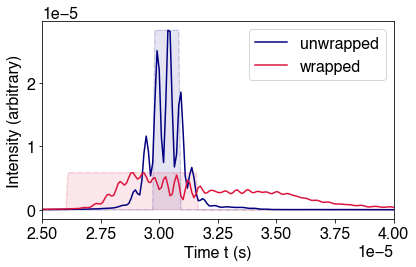

In [81]:
angle = 30
data_0x, data_0y = import_mat(f'../raw_data/0322_focus_{angle}_arc.mat')[1:]
data_1x, data_1y = import_mat(f'../raw_data/0322_focus_wrap_{angle}_arc.mat')[1:]

# Transform to get power through a shell
data_0 = (data_0x.T * np.cos(a/180*np.pi)).T + (data_0y.T * np.sin(a/180*np.pi)).T 
data_1 = (data_1x.T * np.cos(a/180*np.pi)).T + (data_1y.T * np.sin(a/180*np.pi)).T 

elem = np.unravel_index(np.argmax(data_0), data_0.shape)[0]

inc = 55

# Takes all elements of the shell
data_0 = data_0 #[elem-inc:elem+inc,:]
data_1 = data_1

plt.plot(t_range, np.sum(data_0, axis=0), c='navy', label= 'unwrapped')
plt.plot(t_range, np.sum(data_1, axis=0), c='crimson',label = 'wrapped')

plt.legend()
plt.xlim(2.5e-5, 4e-5)

def top_hat(t, x):
    length = simps(x)/np.max(x)
    peak_idx = np.argmax(x)
    
    mask = np.zeros(len(t))
    mask[peak_idx-int(length/2):peak_idx+int(length/2)] = 1
    
    return np.where(mask, np.max(x), 0)

alpha = 0.1
plt.fill_between(t_range, top_hat(t_range, np.sum(data_0, axis=0)), color='navy', alpha=alpha)


plt.fill_between(t_range, top_hat(t_range, np.sum(data_1, axis=0)), color='crimson', alpha=alpha)
plt.plot(t_range, top_hat(t_range, np.sum(data_0, axis=0)), c='navy', ls='dashed', alpha=alpha)
plt.plot(t_range, top_hat(t_range, np.sum(data_1, axis=0)), c='crimson', ls='dashed', alpha=alpha)

plt.ylabel('Intensity (arbitrary)')
plt.xlabel('Time t (s)')

plt.tight_layout()
#plt.savefig('lateral.png', dpi=300)
#plt.savefig('wave.pdf')

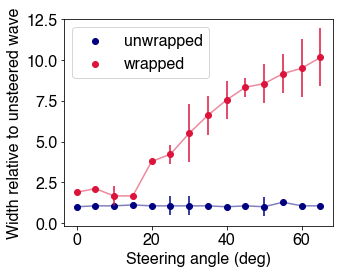

In [99]:
widths_unwrap, widths_wrap = np.array(lengths).T*dt *1e6
widths2_unwrap, widths2_wrap = np.array(widths).T*1e6

unwrapped_err, wrapped_err = (width_hi - width_lo).T/2

factor = widths2_unwrap[0]
widths_unwrap /= factor
widths2_unwrap /= factor
widths_wrap /= factor
widths2_wrap /= factor

size= None
plt.figure(figsize=(5,4))
#plt.scatter(angles, widths_unwrap, c='navy', s=size)
#plt.scatter(angles, widths_wrap, c='crimson', s=size)

plt.errorbar(angles, widths2_wrap, wrapped_err, ls='', c='crimson')
plt.errorbar(angles, widths2_unwrap, unwrapped_err, ls= '', c='navy')

#plt.scatter(angles, widths_unwrap , c='navy', alpha=0.5, ls=':', label='unwrapped, area metric')
#plt.scatter(angles, widths_wrap , c='crimson', alpha=0.5, ls=':', label= 'wrapped, area metric')
plt.plot(angles, widths2_unwrap , c='navy', alpha=0.5, ls='-')
plt.plot(angles, widths2_wrap , c='crimson', alpha=0.5, ls='-')


plt.scatter(angles, widths2_unwrap , c='navy', s=size,  label='unwrapped')
plt.scatter(angles, widths2_wrap , c='crimson', s=size, label='wrapped')



plt.xlabel('Steering angle (deg)')
plt.ylabel('Width relative to unsteered wave')
plt.legend()
plt.tight_layout()
plt.savefig('axial-0.pdf')

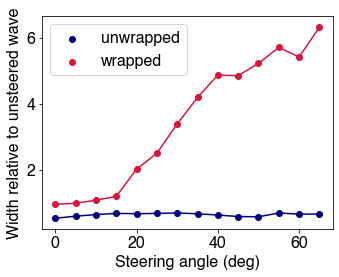

In [100]:
widths_unwrap, widths_wrap = np.array(lengths).T*dt *1e6
widths2_unwrap, widths2_wrap = np.array(widths).T*1e6

unwrapped_err, wrapped_err = (width_hi - width_lo).T/2

factor = widths2_unwrap[0]
widths_unwrap /= factor
widths2_unwrap /= factor
widths_wrap /= factor
widths2_wrap /= factor

size= None
plt.figure(figsize=(5,4))
plt.errorbar(angles, widths_unwrap, 0.05*widths_unwrap, ls='-', c='navy', s=size)
plt.errorbar(angles, widths_wrap,0.05*widths_unwrap, c='crimson',ls='-', s=size)

plt.scatter(angles, widths_unwrap , c='navy', ls='-', label='unwrapped')
plt.scatter(angles, widths_wrap , c='crimson',  ls='-', label= 'wrapped')


plt.xlabel('Steering angle (deg)')
plt.ylabel('Width relative to unsteered wave')
plt.legend()
plt.tight_layout()
plt.savefig('axial-1.pdf')

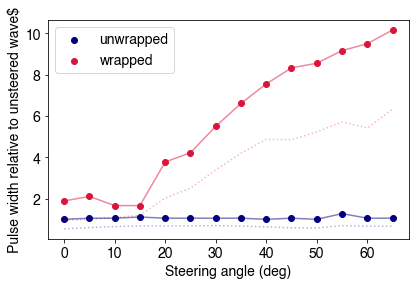

In [184]:
widths_unwrap, widths_wrap = np.array(lengths).T*dt *1e6
widths2_unwrap, widths2_wrap = np.array(widths).T*1e6

factor = widths2_unwrap[0]
widths_unwrap /= factor
widths2_unwrap /= factor
widths_wrap /= factor
widths2_wrap /= factor
size = None

#plt.scatter(angles, widths_unwrap, c='navy', s=size)
#plt.scatter(angles, widths_wrap, c='crimson', s=size)

plt.plot(angles, widths_unwrap , c='navy', alpha=0.3, ls=':')
plt.plot(angles, widths_wrap , c='crimson', alpha=0.3, ls=':')

plt.plot(angles, widths2_unwrap , c='navy', alpha=0.5, ls='-')
plt.plot(angles, widths2_wrap , c='crimson', alpha=0.5, ls='-')


plt.scatter(angles, widths2_unwrap , c='navy', s=size, label='unwrapped')
plt.scatter(angles, widths2_wrap , c='crimson', s=size, label='wrapped')


plt.xlabel('Steering angle (deg)')
plt.ylabel('Relative Pulse width')
plt.legend()
plt.tight_layout()
plt.savefig('axial-2.svg')

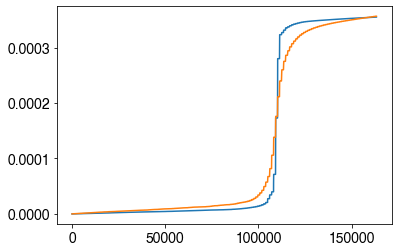

In [108]:
plt.plot(np.cumsum(data_0))
plt.plot(np.cumsum(data_1))

In [ ]:
np.cumsum(data_1).shape

(163251,)

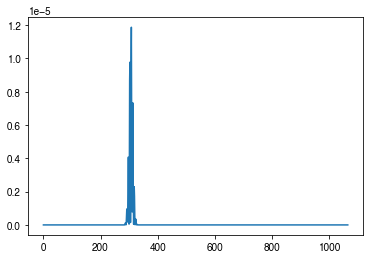

In [ ]:
plt.plot(data_0x[76])

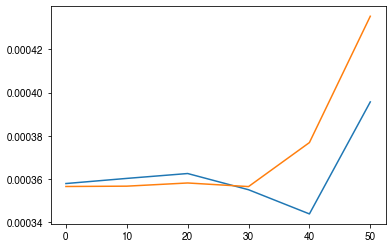

In [ ]:
plt.plot(angles, np.array(areas))

In [ ]:

simps(np.sum(data_0, axis=0), dx=dt), simps(np.sum(data_1, axis=0), dx=dt)

(2.816596710561992e-11, 2.7379234651530384e-11)

(2e-05, 4e-05)

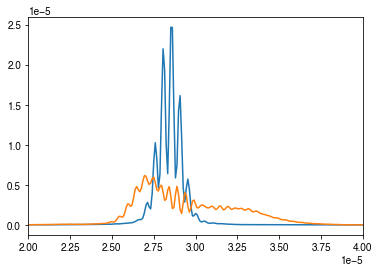

In [ ]:
plt.plot(t_range, np.sum(data_0, axis=0), label= 'unwrapped')
plt.plot(t_range, np.sum(data_1, axis=0), label = 'wrapped')
plt.xlim(2e-5, 4e-5)

# Phantoms

In [1]:
import pandas as pd
anechoic = pd.read_excel('../processed_data/phantom_data.xlsx')
anechoic.head()

,unwrap_CR,unwrap_CNR,wrap_CR,wrap_CNR,steer_CR,steer_CNR
0,0.570193,1.351179,0.025563,0.089328,0.038509,0.139428
1,0.427335,1.074047,0.355603,1.146391,0.077873,0.269744
2,0.559943,1.378757,0.011331,0.039982,0.102650,0.434187
3,0.690773,1.856525,0.185019,0.707197,0.031854,0.119722
4,0.634672,1.575255,0.485507,1.364645,0.057274,0.208749


In [2]:
def get_stats(array):
    """Returns mean and standard error of the mean

    Args:
        array (array like): array you want to analyse

    Returns:
        _type_: _description_
    """
    print('---')
    print(array)
    print(max(array), min(array))
    return np.average(array), np.std(array)

print('CR ', get_stats((anechoic.wrap_CR/ anechoic.unwrap_CR).drop([0,2,6])))
print('CNR', get_stats((anechoic.wrap_CNR/ anechoic.unwrap_CNR).drop([0,2,6])))

---
1    0.832142
3    0.267843
4    0.764972
5    0.391284
7    0.919059
8    0.723621
dtype: float64
0.9190592549253839 0.2678433787606936


NameError: name 'np' is not defined

In [194]:
anechoic.wrap_CR, anechoic.unwrap_CR

(0    0.025563
 1    0.355603
 2    0.011331
 3    0.185019
 4    0.485507
 5    0.241678
 6    0.091584
 7    0.366657
 8    0.190815
 Name: wrap_CR, dtype: float64,
 0    0.570193
 1    0.427335
 2    0.559943
 3    0.690773
 4    0.634672
 5    0.617655
 6    0.345798
 7    0.398949
 8    0.263695
 Name: unwrap_CR, dtype: float64)

In [195]:
anechoic.wrap_CNR, anechoic.unwrap_CNR

(0    0.089328
 1    1.146391
 2    0.039982
 3    0.707197
 4    1.364645
 5    0.867551
 6    0.350630
 7    1.062695
 8    0.794009
 Name: wrap_CNR, dtype: float64,
 0    1.351179
 1    1.074047
 2    1.378757
 3    1.856525
 4    1.575255
 5    2.257976
 6    0.945554
 7    1.002549
 8    0.722849
 Name: unwrap_CNR, dtype: float64)

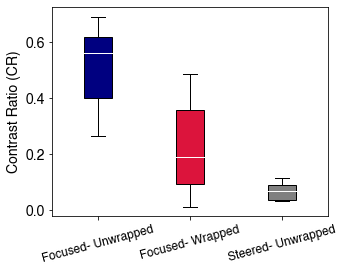

In [213]:
fig, (ax1) = plt.subplots(1,1 , figsize=(5, 4))
bplot1 = ax1.boxplot([anechoic.unwrap_CR, anechoic.wrap_CR, anechoic.steer_CR.dropna()],
    patch_artist= True, medianprops= dict(color='white') )
plt.ylabel('Contrast Ratio (CR)')
plt.xticks([1, 2, 3], ['Focused- Unwrapped', 'Focused- Wrapped', 'Steered- Unwrapped'], size=12, rotation=15)

# fill with colors
colors = [ 'navy','crimson', 'grey']

for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

plt.tight_layout()
plt.savefig('CR.pdf')

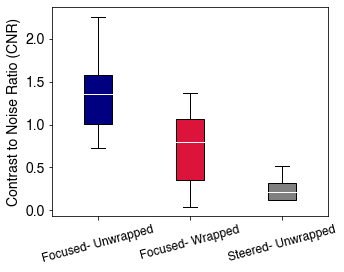

In [215]:
fig, (ax1) = plt.subplots(1,1 , figsize=(5, 4))

bplot1 = ax1.boxplot([anechoic.unwrap_CNR, anechoic.wrap_CNR, anechoic.steer_CNR.dropna()], patch_artist= True, medianprops= dict(color='white') )


plt.ylabel('Contrast to Noise Ratio (CNR)')
plt.xticks([1, 2, 3], ['Focused- Unwrapped', 'Focused- Wrapped', 'Steered- Unwrapped'], size=12, rotation=15)

# fill with colors
colors = [ 'navy','crimson', 'grey']

for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
plt.tight_layout()
plt.savefig('CNR.pdf')